# Deep Learning Starter : Simple LSTM

This notebook leverages the time series structure of the data.

I expect sequential Deep Learning models to dominate in this competition, so here's a simple LSTM architecture.

Parameters were not really tweaked so the baseline is easily improvable.

Code is taken from previous work, some functions are documented but the doc may be outdated.


**Don't fork without upvoting ^^**

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

warnings.filterwarnings("ignore")
NUM_WORKERS = 4

## Data

### Load

In [2]:
DATA_PATH = ""

sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')


df = df_train[df_train['breath_id'] < 5].reset_index(drop=True)

In [4]:
df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [8]:
df.groupby('breath_id')['u_in'].shift(1)

0            NaN
1       0.083334
2      18.383041
3      22.509278
4      22.808822
         ...    
315     4.936515
316     4.946119
317     4.954007
318     4.960767
319     4.966532
Name: u_in, Length: 320, dtype: float64

In [10]:
df['u_in'].shift(1)

0            NaN
1       0.083334
2      18.383041
3      22.509278
4      22.808822
         ...    
315     4.936515
316     4.946119
317     4.954007
318     4.960767
319     4.966532
Name: u_in, Length: 320, dtype: float64

In [11]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [12]:
df_test = add_features(df_test)
df_train = add_features(df_train)
df = add_features(df)

In [13]:
df

,id,breath_id,time_step,u_in,u_out,pressure,area,u_in_lag1,u_out_lag1,u_in_lag_back1,...,cross,cross2,R_20,R_50,C_20,C_50,R__C_20__20,R__C_20__50,R__C_50__20,R__C_50__50
0,1,1,0.000000,0.083334,0,5.837492,0.000000,0.000000,0.0,18.383041,...,0.000000,0.000000,1,0,0,1,0,1,0,0
1,2,1,0.033652,18.383041,0,5.907794,0.618632,0.083334,0.0,22.509278,...,0.000000,0.000000,1,0,0,1,0,1,0,0
2,3,1,0.067514,22.509278,0,7.876254,2.138333,18.383041,0.0,22.808822,...,0.000000,0.000000,1,0,0,1,0,1,0,0
3,4,1,0.101542,22.808822,0,11.742872,4.454391,22.509278,0.0,25.355850,...,0.000000,0.000000,1,0,0,1,0,1,0,0
4,5,1,0.135756,25.355850,0,12.234987,7.896588,22.808822,0.0,27.259866,...,0.000000,0.000000,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,316,4,2.400609,4.946119,1,7.032628,393.557153,4.936515,1.0,4.954007,...,4.946119,2.400609,0,1,0,1,0,0,0,1
316,317,4,2.432266,4.954007,1,6.540513,405.606618,4.946119,1.0,4.960767,...,4.954007,2.432266,0,1,0,1,0,0,0,1
317,318,4,2.464062,4.960767,1,6.399909,417.830256,4.954007,1.0,4.966532,...,4.960767,2.464062,0,1,0,1,0,0,0,1
318,319,4,2.495845,4.966532,1,6.962326,430.225952,4.960767,1.0,4.971585,...,4.966532,2.495845,0,1,0,1,0,0,0,1


In [41]:
len(df_test.columns)

51

In [59]:
df.columns

Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'pressure', 'area',
       'u_in_lag1', 'u_out_lag1', 'u_in_lag_back1', 'u_out_lag_back1',
       'u_in_lag2', 'u_out_lag2', 'u_in_lag_back2', 'u_out_lag_back2',
       'u_in_lag3', 'u_out_lag3', 'u_in_lag_back3', 'u_out_lag_back3',
       'u_in_lag4', 'u_out_lag4', 'u_in_lag_back4', 'u_out_lag_back4',
       'breath_id__u_in__max', 'breath_id__u_out__max', 'u_in_diff1',
       'u_out_diff1', 'u_in_diff2', 'u_out_diff2', 'breath_id__u_in__diffmax',
       'breath_id__u_in__diffmean', 'u_in_diff3', 'u_out_diff3', 'u_in_diff4',
       'u_out_diff4', 'cross', 'cross2', 'R_20', 'R_50', 'C_20', 'C_50',
       'R__C_20__20', 'R__C_20__50', 'R__C_50__20', 'R__C_50__50'],
      dtype='object')

### Viz

In [46]:
def plot_sample(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]
    r, c  = df_breath[['R_20', 'C_20']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['u_in', 'u_out', 'pressure']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    plt.legend()
    plt.title(f'Sample {sample_id} - R={r}, C={c}')

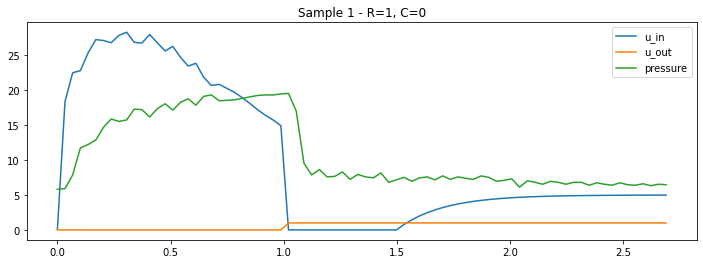

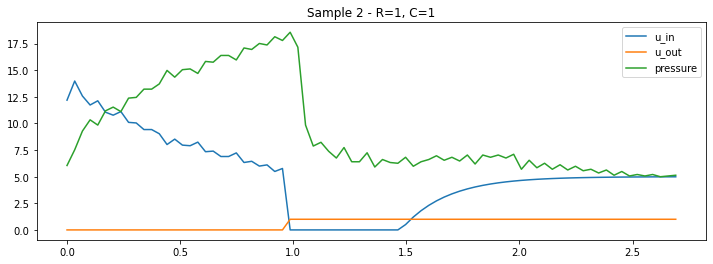

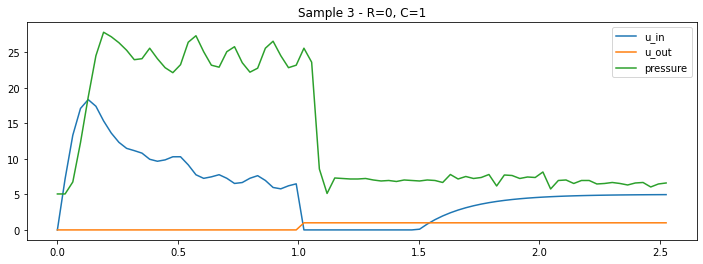

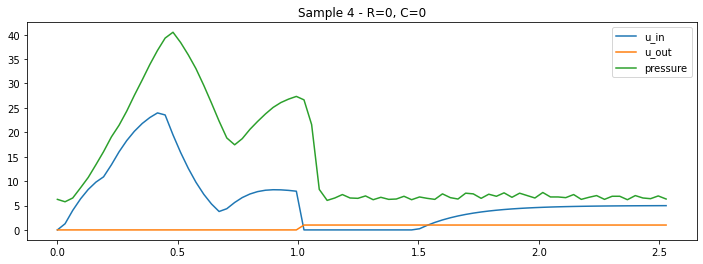

In [47]:
for i in df['breath_id'].unique():
    plot_sample(i, df_train)

### Dataset

In [55]:
import torch
from torch.utils.data import Dataset

class VentilatorDataset(Dataset):
    def __init__(self, df):
        if "pressure" not in df.columns:
            df['pressure'] = 0
            
        self.df = df.groupby('breath_id').agg(list).reset_index()

        self.prepare_data()

    def __len__(self):
        return self.df.shape[0]

    def prepare_data(self):
        self.pressures = np.array(self.df['pressure'].values.tolist())

        u_ins = np.array(self.df['u_in'].values.tolist())
        area = np.array(self.df['area'].values.tolist())
        u_in_lag1 = np.array(self.df['u_in_lag1'].values.tolist())
        u_out_lag1 = np.array(self.df['u_out_lag1'].values.tolist())
        u_in_lag_back1 = np.array(self.df['u_in_lag_back1'].values.tolist())
        u_out_lag_back1 = np.array(self.df['u_out_lag_back1'].values.tolist())
        u_in_lag2 = np.array(self.df['u_in_lag2'].values.tolist())
        u_out_lag2 = np.array(self.df['u_out_lag2'].values.tolist())
        u_in_lag3 = np.array(self.df['u_in_lag3'].values.tolist())
        u_out_lag3 = np.array(self.df['u_out_lag3'].values.tolist())
        u_in_lag_back3 = np.array(self.df['u_in_lag_back3'].values.tolist())
        u_out_lag_back3 = np.array(self.df['u_out_lag_back3'].values.tolist())
        u_in_lag4 = np.array(self.df['u_in_lag4'].values.tolist())
        u_out_lag4 = np.array(self.df['u_out_lag4'].values.tolist())
        u_in_lag_back4 = np.array(self.df['u_in_lag_back4'].values.tolist())
        u_out_lag_back4 = np.array(self.df['u_out_lag_back4'].values.tolist())
        
        breath_id__u_in__max = np.array(self.df['breath_id__u_in__max'].values.tolist())
        breath_id__u_out__max = np.array(self.df['breath_id__u_out__max'].values.tolist())
        u_in_diff1 = np.array(self.df['u_in_diff1'].values.tolist())
        u_out_diff1 = np.array(self.df['u_out_diff1'].values.tolist())
        u_in_diff2 = np.array(self.df['u_in_diff2'].values.tolist())
        u_out_diff2 = np.array(self.df['u_out_diff2'].values.tolist())
        breath_id__u_in__diffmax = np.array(self.df['breath_id__u_in__diffmax'].values.tolist())
        breath_id__u_in__diffmean = np.array(self.df['breath_id__u_in__diffmean'].values.tolist())
        u_in_diff3 = np.array(self.df['u_in_diff3'].values.tolist())
        u_out_diff3 = np.array(self.df['u_out_diff3'].values.tolist())
        u_in_diff4 = np.array(self.df['u_in_diff4'].values.tolist())
        u_out_diff4 = np.array(self.df['u_out_diff4'].values.tolist())
        cross = np.array(self.df['cross'].values.tolist())
        cross2 = np.array(self.df['cross2'].values.tolist())
        
        R_20 = np.array(self.df['R_20'].values.tolist())
        R_5 = np.array(self.df['R_5'].values.tolist())
        R_50 = np.array(self.df['R_50'].values.tolist())
        C_10 = np.array(self.df['C_10'].values.tolist())
        C_20 = np.array(self.df['C_20'].values.tolist())
        C_50 = np.array(self.df['C_50'].values.tolist())
        R__C_20__10 = np.array(self.df['R__C_20__10'].values.tolist())
        R__C_20__20 = np.array(self.df['R__C_20__20'].values.tolist())
        R__C_20__50 = np.array(self.df['R__C_20__50'].values.tolist())
        R__C_50__10 = np.array(self.df['R__C_50__10'].values.tolist())
        R__C_50__20 = np.array(self.df['R__C_50__20'].values.tolist())
        R__C_50__50 = np.array(self.df['R__C_50__50'].values.tolist())
        R__C_5__10 = np.array(self.df['R__C_5__10'].values.tolist())
        R__C_5__20 = np.array(self.df['R__C_5__20'].values.tolist())
        R__C_5__50 = np.array(self.df['R__C_5__50'].values.tolist())
        

        self.u_outs = np.array(self.df['u_out'].values.tolist())
        
        self.inputs = np.concatenate([
            u_ins[:, None], 
            np.cumsum(u_ins, 1)[:, None],
            self.u_outs[:, None],
            area[:, None], 
            u_in_lag1[:, None], 
            u_out_lag1[:, None], 
            u_in_lag_back1[:, None], 
            u_out_lag_back1[:, None], 
            u_in_lag2[:, None], 
            u_out_lag2[:, None], 
            u_in_lag3[:, None], 
            u_out_lag3[:, None], 
            u_in_lag_back3[:, None], 
            u_out_lag_back3[:, None], 
            u_in_lag4[:, None], 
            u_out_lag4[:, None], 
            u_in_lag_back4[:, None], 
            u_out_lag_back4[:, None],
            breath_id__u_in__max[:, None],
            breath_id__u_out__max[:, None],
            u_in_diff1[:, None],
            u_out_diff1[:, None],
            u_in_diff2[:, None],
            u_out_diff2[:, None],
            breath_id__u_in__diffmax[:, None],
            breath_id__u_in__diffmean[:, None],
            u_in_diff3[:, None],
            u_out_diff3[:, None],
            u_in_diff4[:, None],
            u_out_diff4[:, None],
            cross[:, None],
            cross2[:, None],
            R_20[:, None],
            R_5[:, None],
            R_50[:, None],
            C_10[:, None],
            C_20[:, None],
            C_50[:, None],
            R__C_20__10[:, None],
            R__C_20__20[:, None],
            R__C_20__50[:, None],
            R__C_50__10[:, None],
            R__C_50__20[:, None],
            R__C_50__50[:, None],
            R__C_5__10[:, None],
            R__C_5__20[:, None],
            R__C_5__50[:, None]
        ], 1).transpose(0, 2, 1)

    def __getitem__(self, idx):
        data = {
            "input": torch.tensor(self.inputs[idx], dtype=torch.float),
            "u_out": torch.tensor(self.u_outs[idx], dtype=torch.float),
            "p": torch.tensor(self.pressures[idx], dtype=torch.float),
        }
        
        return data

In [60]:
dataset = VentilatorDataset(df_train)
dataset[0]

{'input': tensor([[8.3334e-02, 8.3334e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.8383e+01, 1.8466e+01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.2509e+01, 4.0976e+01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [4.9818e+00, 8.0171e+02, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.9847e+00, 8.0669e+02, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.9871e+00, 8.1168e+02, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 'u_out': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]),
 'p':

In [66]:
dataset.inputs.shape

(75450, 80, 47)

## Model
- 2 Layer MLP
- Bidirectional LSTM
- Prediction dense layer

In [11]:
import torch
import torch.nn as nn


class RNNModel(nn.Module):
    def __init__(
        self,
        input_dim=4,
        lstm_dim=256,
        dense_dim=256,
        logit_dim=256,
        num_classes=1,
    ):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, dense_dim // 2),
            nn.ReLU(),
            nn.Linear(dense_dim // 2, dense_dim),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(dense_dim, lstm_dim, batch_first=True, bidirectional=True)

        self.logits = nn.Sequential(
            nn.Linear(lstm_dim * 2, logit_dim),
            nn.ReLU(),
            nn.Linear(logit_dim, num_classes),
        )

    def forward(self, x):
        features = self.mlp(x)
        features, _ = self.lstm(features)
        pred = self.logits(features)
        return pred

## Training

### Utils

In [12]:
import os
import torch
import random
import numpy as np


def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.

    Args:
        seed (int): Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    
def count_parameters(model, all=False):
    """
    Counts the parameters of a model.

    Args:
        model (torch model): Model to count the parameters of.
        all (bool, optional):  Whether to count not trainable parameters. Defaults to False.

    Returns:
        int: Number of parameters.
    """
    if all:
        return sum(p.numel() for p in model.parameters())
    else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    
def worker_init_fn(worker_id):
    """
    Handles PyTorch x Numpy seeding issues.

    Args:
        worker_id (int): Id of the worker.
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def save_model_weights(model, filename, verbose=1, cp_folder=""):
    """
    Saves the weights of a PyTorch model.

    Args:
        model (torch model): Model to save the weights of.
        filename (str): Name of the checkpoint.
        verbose (int, optional): Whether to display infos. Defaults to 1.
        cp_folder (str, optional): Folder to save to. Defaults to "".
    """
    if verbose:
        print(f"\n -> Saving weights to {os.path.join(cp_folder, filename)}\n")
    torch.save(model.state_dict(), os.path.join(cp_folder, filename))

### Metric & Loss
> The competition will be scored as the mean absolute error between the predicted and actual pressures during the inspiratory phase of each breath. The expiratory phase is not scored.

In [13]:
def compute_metric(df, preds):
    """
    Metric for the problem, as I understood it.
    """
    
    y = np.array(df['pressure'].values.tolist())
    w = 1 - np.array(df['u_out'].values.tolist())
    
    assert y.shape == preds.shape and w.shape == y.shape, (y.shape, preds.shape, w.shape)
    
    mae = w * np.abs(y - preds)
    mae = mae.sum() / w.sum()
    
    return mae


class VentilatorLoss(nn.Module):
    """
    Directly optimizes the competition metric
    """
    def __call__(self, preds, y, u_out):
        w = 1 - u_out
        mae = w * (y - preds).abs()
        mae = mae.sum(-1) / w.sum(-1)

        return mae

### Fit

In [14]:
import gc
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup


def fit(
    model,
    train_dataset,
    val_dataset,
    loss_name="L1Loss",
    optimizer="Adam",
    epochs=50,
    batch_size=32,
    val_bs=32,
    warmup_prop=0.1,
    lr=1e-3,
    num_classes=1,
    verbose=1,
    first_epoch_eval=0,
    device="cuda"
):
    avg_val_loss = 0.

    # Optimizer
    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=lr)

    # Data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=worker_init_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=val_bs,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    # Loss
#     loss_fct = getattr(torch.nn, loss_name)(reduction="none")
    loss_fct = VentilatorLoss()

    # Scheduler
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = int(epochs * len(train_loader))
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps, num_training_steps
    )

    for epoch in range(epochs):
        model.train()
        model.zero_grad()
        start_time = time.time()

        avg_loss = 0
        for data in train_loader:
            pred = model(data['input'].to(device)).squeeze(-1)

            loss = loss_fct(
                pred,
                data['p'].to(device),
                data['u_out'].to(device),
            ).mean()
            loss.backward()
            avg_loss += loss.item() / len(train_loader)

            optimizer.step()
            scheduler.step()

            for param in model.parameters():
                param.grad = None

        model.eval()
        mae, avg_val_loss = 0, 0
        preds = []

        with torch.no_grad():
            for data in val_loader:
                pred = model(data['input'].to(device)).squeeze(-1)

                loss = loss_fct(
                    pred.detach(), 
                    data['p'].to(device),
                    data['u_out'].to(device),
                ).mean()
                avg_val_loss += loss.item() / len(val_loader)

                preds.append(pred.detach().cpu().numpy())
        
        preds = np.concatenate(preds, 0)
        mae = compute_metric(val_dataset.df, preds)

        elapsed_time = time.time() - start_time
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            lr = scheduler.get_last_lr()[0]
            print(
                f"Epoch {epoch + 1:02d}/{epochs:02d} \t lr={lr:.1e}\t t={elapsed_time:.0f}s \t"
                f"loss={avg_loss:.3f}",
                end="\t",
            )

            if (epoch + 1 >= first_epoch_eval) or (epoch + 1 == epochs):
                print(f"val_loss={avg_val_loss:.3f}\tmae={mae:.3f}")
            else:
                print("")

    del (val_loader, train_loader, loss, data, pred)
    gc.collect()
    torch.cuda.empty_cache()

    return preds


### Predict

In [15]:
def predict(
    model,
    dataset,
    batch_size=64,
    device="cuda"
):
    """
    Usual torch predict function. Supports sigmoid and softmax activations.
    Args:
        model (torch model): Model to predict with.
        dataset (PathologyDataset): Dataset to predict on.
        batch_size (int, optional): Batch size. Defaults to 64.
        device (str, optional): Device for torch. Defaults to "cuda".

    Returns:
        numpy array [len(dataset) x num_classes]: Predictions.
    """
    model.eval()

    loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )
    
    preds = []
    with torch.no_grad():
        for data in loader:
            pred = model(data['input'].to(device)).squeeze(-1)
            preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds, 0)
    return preds

## Train

In [16]:
def train(config, df_train, df_val, df_test, fold):
    """
    Trains and validate a model.

    Args:
        config (Config): Parameters.
        df_train (pandas dataframe): Training metadata.
        df_val (pandas dataframe): Validation metadata.
        df_test (pandas dataframe): Test metadata.
        fold (int): Selected fold.

    Returns:
        np array: Study validation predictions.
    """

    seed_everything(config.seed)

    model = RNNModel(
        input_dim=config.input_dim,
        lstm_dim=config.lstm_dim,
        dense_dim=config.dense_dim,
        logit_dim=config.logit_dim,
        num_classes=config.num_classes,
    ).to(config.device)
    model=nn.DataParallel(model,device_ids=[0,1,2]) # multi-GPU
    model.zero_grad()

    train_dataset = VentilatorDataset(df_train)
    val_dataset = VentilatorDataset(df_val)
    test_dataset = VentilatorDataset(df_test)

    n_parameters = count_parameters(model)

    print(f"    -> {len(train_dataset)} training breathes")
    print(f"    -> {len(val_dataset)} validation breathes")
    print(f"    -> {n_parameters} trainable parameters\n")

    pred_val = fit(
        model,
        train_dataset,
        val_dataset,
        loss_name=config.loss,
        optimizer=config.optimizer,
        epochs=config.epochs,
        batch_size=config.batch_size,
        val_bs=config.val_bs,
        lr=config.lr,
        warmup_prop=config.warmup_prop,
        verbose=config.verbose,
        first_epoch_eval=config.first_epoch_eval,
        device=config.device,
    )
    
    pred_test = predict(
        model, 
        test_dataset, 
        batch_size=config.val_bs, 
        device=config.device
    )

    if config.save_weights:
        save_model_weights(
            model,
            f"{config.selected_model}_{fold}.pt",
            cp_folder="",
        )

    del (model, train_dataset, val_dataset, test_dataset)
    gc.collect()
    torch.cuda.empty_cache()

    return pred_val, pred_test

### $k$-fold

In [17]:
from sklearn.model_selection import GroupKFold

def k_fold(config, df, df_test):
    """
    Performs a patient grouped k-fold cross validation.
    """

    pred_oof = np.zeros(len(df))
    preds_test = []
    
    gkf = GroupKFold(n_splits=config.k)
    splits = list(gkf.split(X=df, y=df, groups=df["breath_id"]))

    for i, (train_idx, val_idx) in enumerate(splits):
        if i in config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {config.k}  -------------\n")

            df_train = df.iloc[train_idx].copy().reset_index(drop=True)
            df_val = df.iloc[val_idx].copy().reset_index(drop=True)

            pred_val, pred_test = train(config, df_train, df_val, df_test, i)
            
            pred_oof[val_idx] = pred_val.flatten()
            preds_test.append(pred_test.flatten())

    print(f'\n -> CV MAE : {compute_metric(df, pred_oof) :.3f}')

    return pred_oof, np.mean(preds_test, 0)

## Main

In [18]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 4
    selected_folds = [0, 1, 2, 3]
    
    # Model
    selected_model = 'rnn'
    input_dim = 47

    # dense_dim = 512
    # lstm_dim = 512
    # logit_dim = 512
    # num_classes = 1
    dense_dim = 256
    lstm_dim = 256
    logit_dim = 256
    num_classes = 1
    
    # Training
    loss = "L1Loss"  # not used
    optimizer = "Adam"
    batch_size = 128
    epochs = 200

    lr = 1e-3
    warmup_prop = 0

    val_bs = 256
    first_epoch_eval = 0

In [19]:
pred_oof, pred_test = k_fold(
    Config, 
    df_train,
    df_test,
)


-------------   Fold 1 / 5  -------------

    -> 60360 training breathes
    -> 15090 validation breathes
    -> 4860929 trainable parameters



### Predictions

In [ ]:
def plot_prediction(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['pred', 'pressure', 'u_out']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    metric = compute_metric(df_breath, df_breath['pred'])
        
    plt.legend()
    plt.title(f'Sample {sample_id} - MAE={metric:.3f}')

In [ ]:
df_train["pred"] = pred_oof

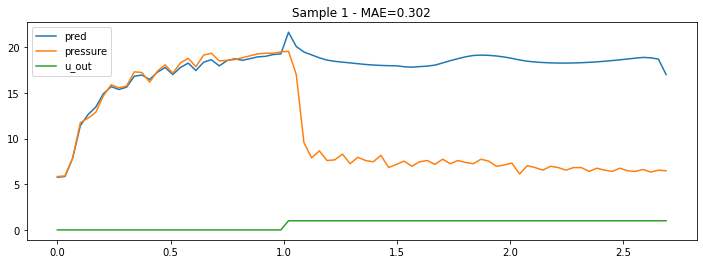

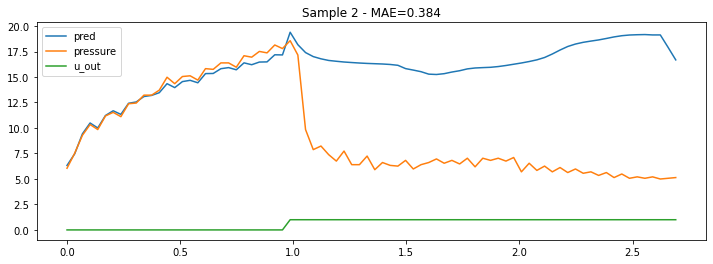

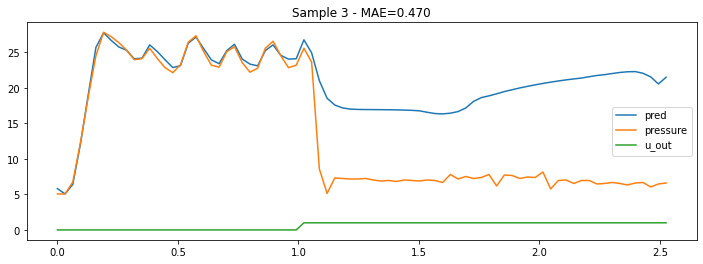

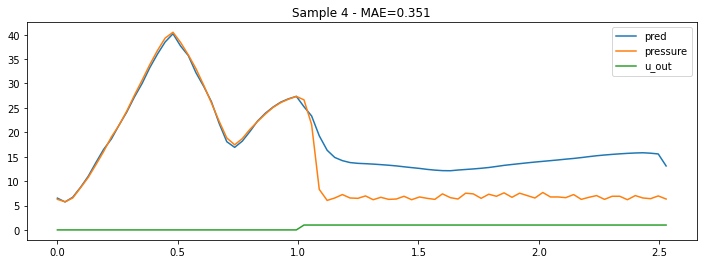

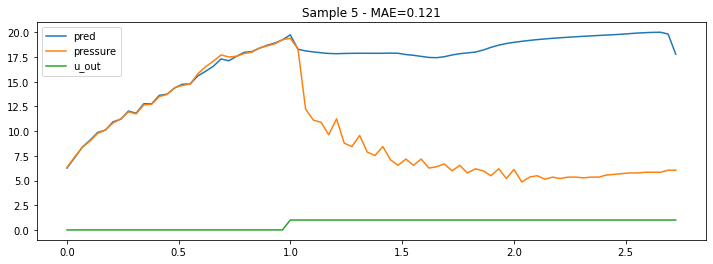

In [ ]:
for i in df_train['breath_id'].unique()[:5]:
    plot_prediction(i, df_train)

## Sub

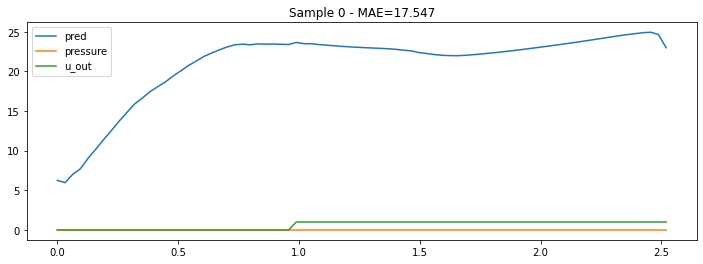

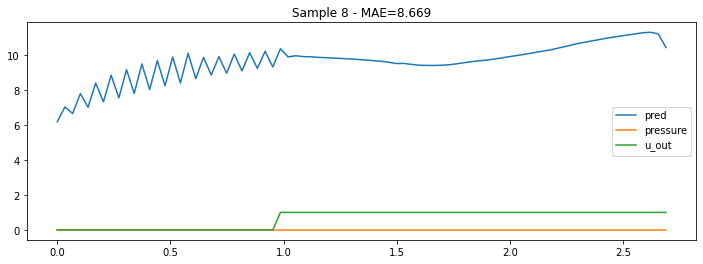

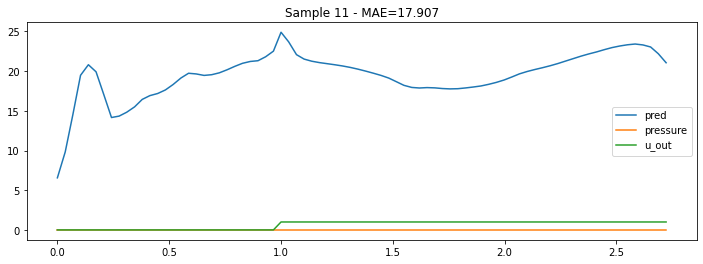

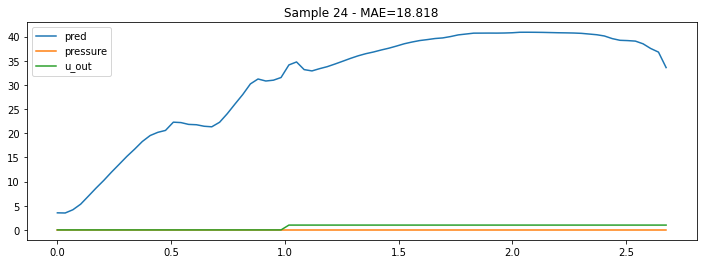

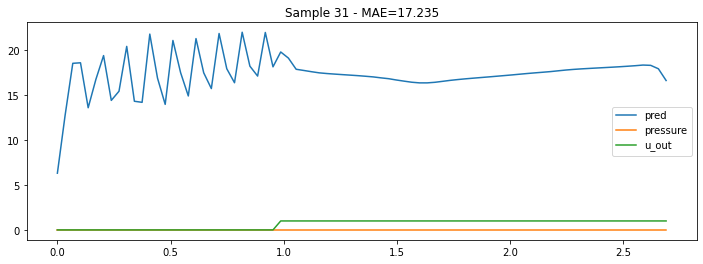

In [ ]:
df_test['pred'] = pred_test

for i in df_test['breath_id'].unique()[:5]:
    plot_prediction(i, df_test)

In [ ]:
sub['pressure'] = pred_test
sub.to_csv('submission.csv', index=False)

**Thanks for reading !**